In [1]:
import normalize
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction import DictVectorizer
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif, mutual_info_classif, SelectKBest, RFE, VarianceThreshold
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.over_sampling import SMOTE
import pandas as pd 
import numpy as np 
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.formula.api as sm
from collections import Counter
# import lime
# import lime.lime_tabular
import math
warnings.filterwarnings("ignore")
%matplotlib inline

# Methods

In [2]:
def show_kbest(data_frame, target, linear_rel=True, k=4):
    """
    Selecting K-Best features for classification
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    scores = []
    if linear_rel == True: 
        feat_selector = SelectKBest(f_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "F Score"
    else:
        feat_selector = SelectKBest(mutual_info_classif, k=k)
        _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
        col_name = "Mutual Information"
    
    feat_scores = pd.DataFrame()
    feat_scores[col_name] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 

def preprocess_data_frame(data_frame, columns):
    """
    Dummifying and encoding variables of dataframe, droping rows with NAN values
    :param data_frame: A pandas DataFrame to be processed
    pandas DataFrame
    :param columns: List of column names of categorical variables 
    :returns data_frame: encoded variable DataFrame
    """
    data_frame = data_frame.dropna()
    data_frame = data_frame.reset_index(drop=True)
    
    for col in columns:
#         print(data_frame[col])
        data_frame[col] = encode_variable(data_frame[col])
#         print(data_frame[col])
    data_frame = pd.get_dummies(data_frame)
    return data_frame
    
def encode_variable(series):
    """
    Encoding categorical variables to numericial values
    :param series: A pandas Series with categorical values
    pandas DataFrame
    :returns data_frame: encoded variable DataFrame
    """
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(series)
    print(list(le.classes_))
    print(set(le.transform(series))) 
    data_frame = pd.DataFrame({
        series.name: le.transform(series)
    })
    return data_frame
    
def split_dataframe(data_frame, target):
    """
    Split dataframe to predictors and target
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :returns DataFrames: X (predictors) and y (target) dataframes 
    """
    X = data_frame.drop([target], axis=1)
    y = encode_variable(data_frame[target])
    return X, y 

def get_features_variance_threshold(data_frame,target="gender", threshold=0.2):
    """
    Returns list of features with a variance above the specified threshold
    :param data_frame: A pandas dataFrame with the training data
    :param threshold: float value between 0 and 1 
    :returns feature_scores: list of features
    """
    if target in data_frame.columns:
        data_frame = data_frame.drop([target], axis=1)
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(data_frame)
    # Get the indices of zero variance feats
    feat_ix_keep = selector.get_support(indices=True)
#     print(feat_ix_keep)
    return data_frame.columns[feat_ix_keep]

def get_features_univariate(data_frame, k=5, linear=True, target="gender"):
    """
    Returns list of features selected using the specified univariate method
    :param data_frame: A pandas dataFrame with the training data
    :param k: top k features to select  
    :returns data_frame: with selected features
    """
    df = show_kbest(data_frame,target=target,linear_rel=linear, k=k)
    df = df[df["Support"] == True]
    columns = df["Attribute"].values
    return columns

def get_features_rfe(data_frame,model,k=5):
    """
    Returns list of features (k specified) selected using RFE for
    :param data_frame: A pandas dataFrame with features and labels
    :param k: top k features to select  
    :returns list: most relevant features 
    """
    X = data_frame.drop("gender", axis=1)
    y = data_frame["gender"]
    selector = RFE(model, k, step=1)
    selector = selector.fit(X, y)
#     print(selector.support_)
    df = pd.DataFrame({
        "feature": X.columns,
        "support": selector.support_
    })
    return list(df[df["support"] == True]["feature"])

    
    
def under_sample(X,y):
    """ Returns resampled features and labels
    :param X: Features data frame
    :param y: Label data frame
    :return X_resampled, y_resampled: Numpy features array and corresponding lable array
    """
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_sample(X, y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled

def generate_classification_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report
    :param X: Features data frame
    :param y: Label data frame
    :param model: Sklearn model object
    """
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
#     y_test = list(np.array(y_test).flatten())
#     y_train = list(np.array(y_train).flatten())
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    target_names = ['female', 'male']
    mean = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").mean()
    var = cross_val_score(model, X_test, y_test, cv=10, scoring="accuracy").var()
#     print("Cross Validated Accuracy: mean - {}, var - {}".format(mean, var))
    print("Accuracy Score: {} Var: {}".format(mean, var))
    print("\nConfusion Matrix:\n")
    print(confusion_matrix(y_test, pred))
    print("\nClassification Report:\n")
    print(classification_report(y_test, pred, target_names=target_names))
    
def change_of_evaluation_rfe(X_train, X_test,y_train,y_test,model, metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    base = pd.concat([pd.concat([X_train,X_test]), pd.concat([y_train,y_test])], axis=1)
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in range(len(X.columns),0,-1):
        columns = get_features_rfe(base,model,k)
        X_tr = X_train[columns]
        X_te = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_te, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_te, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,model, metric="precision", linear=True):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param linear: If true > F-score if false > mutual information
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    :return num_features: Returns the top k features to be selected
    """
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    data = pd.concat([X,y], axis=1)
    score = []
    for k in range(len(X.columns),0,-1):
        df = show_kbest(data,"gender",linear_rel=linear, k=k)
        df = df[df["Support"] == True]
        columns = df["Attribute"].values
        X_tr = X_train[columns]
        X_ts = X_test[columns]

        model.fit(X_tr, y_train)
        mean = cross_val_score(model, X_ts, y_test, cv=10, scoring=metric).mean()
        variance = cross_val_score(model, X_ts, y_test, cv=10).var()

        score.append([k, mean, variance])

    df = pd.DataFrame(score, columns=["num_features", "mean","variance"])
    sns.pointplot(df["num_features"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["num_features"]].values[0][0]

def change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model,metric="precision"):
    """
    Plots accuracy with respect to the number of features left, and prints the names of features
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn classification model object
    :param metric: Metric to show: precision, recall, accuracy
    """
    lst = list(np.arange(0.0, 1.0, 0.1))
    X = pd.concat([X_train,X_test])
    y = pd.concat([y_train,y_test])
    score = []
    for k in lst:
        features = get_features_variance_threshold(X, threshold=k)
        
        X_train = X_train[features]
        X_test = X_test[features]
        
#         print("Variance: {} - features: {}".format(k,features))

        model.fit(X_train, y_train)
        mean = cross_val_score(model, X_test, y_test, cv=10).mean()
        variance = cross_val_score(model, X_test, y_test, cv=10).var()
        score.append([k, mean, variance])
#     print(score)
    df = pd.DataFrame(score, columns=["variance", "mean", "std"])
    sns.pointplot(df["variance"], df["mean"])
    plt.show()
    return df.sort_values("mean", ascending=False)[["variance"]].values[0][0]
    
def full_report(X_train, X_test, y_train, y_test, model):
    """ Prints classification report for model over different feature selection models
    :param X_train: A pandas dataFrame with train features
    :param X_test: A pandas dataFrame with test features
    :param y_train: A pandas dataFrame with train labels
    :param y_test: A pandas dataFrame with test labels
    :param model: Sklearn object
    """
    X = pd.concat([X_train, X_test])
    y = pd.concat([y_train, y_test])
    
    base = pd.concat([X,y], axis=1)
    print("""###############################################################""")
    print("""Feature Selection: F-SCORE: \n""")
    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=True)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: MUTUAL INFORMATION: \n""")

    k = change_of_evaluation_univariate_feature_selection(X_train, X_test, y_train, y_test,
                                                              model,linear=False, metric="accuracy")
    features = get_features_univariate(base, k=k, linear=False)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    print("""###############################################################""")
    print("""Feature Selection: Variance Threshold: \n""")
    v = change_of_evaluation_variance_threshold(X_train, X_test, y_train, y_test,model, metric="accuracy")
#     print(v)
    features = get_features_variance_threshold(base,threshold=v)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, r_forest)
    
    print("""###############################################################""")
    print("""Feature Selection: RFE: \n""")
    k = change_of_evaluation_rfe(X_train, X_test, y_train, y_test,
                                 model,metric='accuracy')
    features = get_features_rfe(base,model, k=k)
    print("Number of features: ", len(features))
    print("Features: ", features)
    generate_classification_report(X_train, X_test, y_train, y_test, model)



In [3]:
def over_sample(X,y):
    """
    Does the hybrid oversampling with SMOTE
    :param X: Dataframe with predictor atributes
    :param y: Dataframe with labels
    :return X_resampled, y_resampled:
    """
    sm = SMOTE(random_state=42)
    X,y = sm.fit_sample(X, y)
    print(X.shape, y.shape)
    return X,y

def train_test_dfs(X,y,test_size=0.2):
    """
    Returns train, test dataframees
    :parma X: data frame with predictor atributes 
    :parma y: data frame with labels 
    :parma test_size: fraction of data set to be assigned to the test set
    :return X_train, X_test, y_train, y_test:
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train = pd.DataFrame(X_train, columns=X.columns)
    X_test = pd.DataFrame(X_test, columns=X.columns)
    y_train = pd.DataFrame(y_train, columns=y.columns)
    y_test = pd.DataFrame(y_test, columns=y.columns)
    return X_train, X_test, y_train, y_test

def evaluate_model(estimator, X_train, X_test, y_train, y_test): 
    """
    Prints accuracy, confusion matrix and classification report
    """
    target_names = ['female', 'male']
    estimator.fit(X_train,y_train)
    print(accuracy_score(y_test, estimator.predict(X_test)))
    print(confusion_matrix(y_test, estimator.predict(X_test)))
    print(classification_report(y_test, estimator.predict(X_test), target_names=target_names))
    
def get_ac_pr_re_f1(estimator, X,y):
    """
    Returns:
    Accuracy, Precission, Recall, F1-Score
    """
    estimator.fit(X_train,y_train)
    predict = estimator.predict(X_test)
    acc = cross_val_score(estimator, X,y,scoring="accuracy", cv=10).mean()
    re = cross_val_score(estimator, X,y,scoring="recall", cv=10).mean()
    pr = cross_val_score(estimator, X,y,scoring="precision", cv=10).mean()
    f1 = cross_val_score(estimator, X,y,scoring="f1", cv=10).mean()
    return acc,pr,re,f1

def model_comparison_df(estimator_dict, X,y):
    """
    Returns table with model performance comparisson
    """
    lst = []
    for k,v in estimator_dict.items():
        acc, pr, re, f1 = get_ac_pr_re_f1(v, X,y)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Algorithm", "Accuracy", "Precision", "Recall", "F1"])

def print_latex(df, col_format="|c|c|c|c|c|"):
    """ Prints the latex syntax equivalent to the passed dataframe
    :param df: Pandas dataframe 
    :col_format : String indicating the format of columns
    """
    df = df.round(2)
    latex = df.to_latex(column_format=col_format, index=False).replace('toprule',
                                            "hline").replace('midrule',
                                            "hline").replace('bottomrule',
                                            "hline").replace("\\\\\n",
                                            "\\\\\n\\hline").replace("\hline\hline","\hline")
    print(latex)

In [4]:
# get_ac_pr_re_f1(r_forest,X_over,y_over)

# Load the data

In [41]:
data = pd.read_pickle("../data/final_sets/model_large/2016")

# Preprocess and Normalize

In [42]:
data = preprocess_data_frame(data, ["gender"])
data.gender.value_counts()

['female', 'male']
{0, 1}


1    36340
0     5594
Name: gender, dtype: int64

   index  gender  entered  efficiency  eig_central  in_degree    k_core  \
0      0       1     2007   -0.696407    -0.160213  -0.131467 -0.001965   

   out_degree     views  age       ...         phs  act  ply  other_o  \
0    0.001985 -0.118879    0       ...           0    0    0        1   

   is_alive_no  is_alive_unknown  is_alive_yes  year_interval_1  \
0            1                 0             0                0   

   year_interval_2  year_interval_3  
0                1                0  

[1 rows x 49 columns]


C:\Users\Latitude E7450\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\Latitude E7450\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\Latitude E7450\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


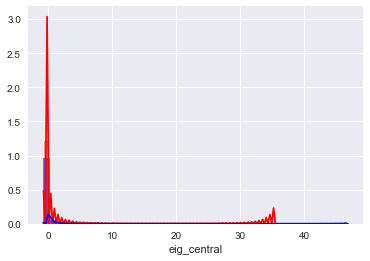

In [43]:
data = normalize.zscore_wikipedia_entered(data, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
print(data.head(1))
data.head()

sns.distplot(data.eig_central, color="grey")
sns.distplot(data[data["gender"]==0].eig_central, color="red")
sns.distplot(data[data["gender"]==1].eig_central, color="blue")



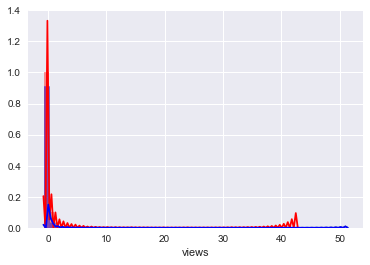

In [8]:
sns.distplot(data.views, color="grey")
sns.distplot(data[data["gender"]==0].views, color="red")
sns.distplot(data[data["gender"]==1].views, color="blue")



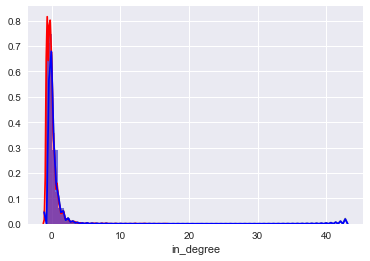

In [9]:
sns.distplot(data.in_degree, color="grey")
sns.distplot(data[data["gender"]==0].in_degree, color="red")
sns.distplot(data[data["gender"]==1].in_degree, color="blue")


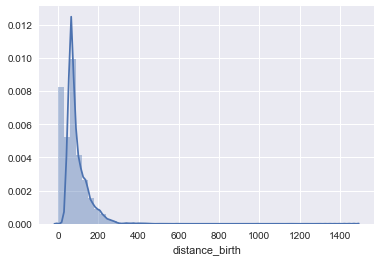

In [10]:
sns.distplot(data["distance_birth"])

C:\Users\Latitude E7450\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\Latitude E7450\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\Latitude E7450\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


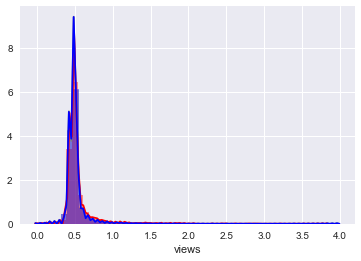

In [44]:
data = normalize.normalize(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])

sns.distplot(data.views, color="grey")
sns.distplot(data[data["gender"]==0].views, color="red")
sns.distplot(data[data["gender"]==1].views, color="blue")
#data["views"].hist()

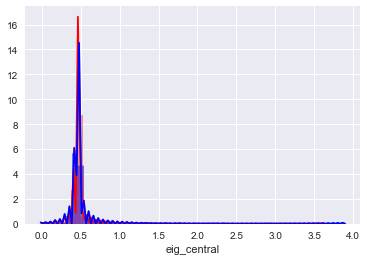

In [12]:
sns.distplot(data.eig_central, color="grey")
sns.distplot(data[data["gender"]==0].eig_central, color="red")
sns.distplot(data[data["gender"]==1].eig_central, color="blue")

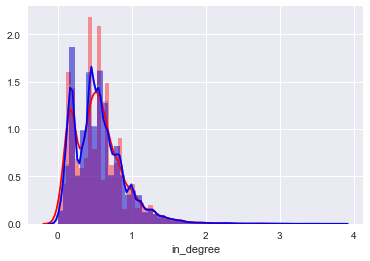

In [13]:
sns.distplot(data.in_degree, color="grey")
sns.distplot(data[data["gender"]==0].in_degree, color="red")
sns.distplot(data[data["gender"]==1].in_degree, color="blue")

In [14]:
data.shape

(41934, 49)

In [15]:
data.gender.value_counts()

1    36340
0     5594
Name: gender, dtype: int64

In [45]:
data = data.drop(['index', 'distance_delta','us', 'de', 'fr', 'in', 'cd', 'no', 
                 'ru', 'gb','other_n', 'dem', 'rep', 'indi', 'inc', 'cpc', 'bjp', 'other_p',
                'year_interval_1', 'year_interval_2', 'year_interval_3','is_alive_no','is_alive_unknown'], axis=1)
data.columns

Index(['gender', 'entered', 'efficiency', 'eig_central', 'in_degree', 'k_core',
       'out_degree', 'views', 'age', 'distance_birth', 'distance_death',
       'nationality_num', 'party_num', 'occupation_num', 'wrt', 'sci', 'jor',
       'eco', 'hst', 'spo', 'lyr', 'phs', 'act', 'ply', 'other_o',
       'is_alive_yes'],
      dtype='object')

# Machine Learning

In [46]:
X,y=split_dataframe(data,"gender")

[0, 1]
{0, 1}


In [47]:
X.head()

,entered,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,distance_death,...,jor,eco,hst,spo,lyr,phs,act,ply,other_o,is_alive_yes
0,2007,1.755516,0.465410,0.555589,1.064854,0.927400,0.483139,0,-1,27,...,0,0,0,0,0,0,0,0,1,0
1,2005,1.925485,0.613149,0.874756,1.326586,1.136243,0.471704,70,70,-1,...,0,0,0,0,0,0,0,0,1,1
2,2013,1.699453,0.556920,0.813674,1.578767,1.367655,0.417380,62,78,16,...,0,0,0,0,0,0,0,0,0,0
3,2007,1.985118,0.434374,0.555589,1.177634,1.052672,0.520954,88,88,-1,...,0,0,0,0,0,0,0,0,1,1
4,2007,1.812793,0.482515,0.871223,1.064854,1.163983,0.528368,84,109,25,...,0,0,0,0,0,0,0,0,1,0


In [48]:
# y.head()

In [49]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# y_test = list(np.array(y_test.values).flatten())
# y_train = list(np.array(y_train.values).flatten())

In [50]:
# #data.boxplot(column="views", by="gender")

# # plot boxplot with seaborn
# bplot=sns.boxplot(y='views', x='gender', 
#                  data=data, 
#                  width=0.5,
#                  palette="colorblind")
 
# # add swarmplot
# bplot=sns.swarmplot(y='views', x='gender',
#               data=data, 
#               color='black',
#               alpha=0.75)


# Algorithms

In [51]:
# SVM
s_vm = svm.SVC()
# Logistic regression
log_reg = LogisticRegression()
# Decision Tree
d_tree = tree.DecisionTreeClassifier()
# Random Forest
r_forest = RandomForestClassifier()

estimator_dict = {
    "SVM": s_vm,
    "Logistic Regression": log_reg,
    "Decision Tree": d_tree,
    "Random Forest": r_forest
}

# Oversampling 

In [23]:
X_over, y_over = over_sample(X,y)
X_over = pd.DataFrame(X_over, columns=X.columns)
y_over = pd.DataFrame(y_over, columns=["gender"])
y_over["gender"].value_counts()

(72680, 24) (72680,)


1    36340
0    36340
Name: gender, dtype: int64

In [24]:
X_train, X_test, y_train, y_test = train_test_dfs(X_over,y_over)

print(y_train["gender"].value_counts())
print(y_test["gender"].value_counts())

0    29092
1    29052
Name: gender, dtype: int64
1    7288
0    7248
Name: gender, dtype: int64


In [25]:
# y_train["gender"].value_counts()

In [26]:
#this was never used!!!

#X_train_norm = normalize.zscore_wikipedia_entered(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalize.zscore_wikipedia_entered(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

#X_train_norm = normalize.normalize(X_train_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalize.normalize(X_test_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])

In [27]:
X_over.head()

,efficiency,eig_central,in_degree,k_core,out_degree,views,age,distance_birth,distance_death,nationality_num,...,jor,eco,hst,spo,lyr,phs,act,ply,other_o,is_alive_yes
0,1.755516,0.465410,0.555589,1.064854,0.927400,0.483139,0.0,-1.0,27.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.925485,0.613149,0.874756,1.326586,1.136243,0.471704,70.0,70.0,-1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1.699453,0.556920,0.813674,1.578767,1.367655,0.417380,62.0,78.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.985118,0.434374,0.555589,1.177634,1.052672,0.520954,88.0,88.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.812793,0.482515,0.871223,1.064854,1.163983,0.528368,84.0,109.0,25.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## SVM

In [28]:
cross_val_score(s_vm,X_over,y_over,scoring='accuracy',cv=10)

array([0.69523941, 0.68175564, 0.69964227, 0.69413869, 0.70005504,
       0.69056136, 0.70088057, 0.68822234, 0.68024216, 0.67294992])

## Logistic Regression

In [29]:
cross_val_score(log_reg,X_over,y_over,scoring='accuracy',cv=10)

array([0.64900936, 0.63126032, 0.65561365, 0.64364337, 0.65093561,
       0.64419373, 0.6575399 , 0.65478811, 0.64116676, 0.64047881])

In [30]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

0.6472894881673088
[[5461 1787]
 [3340 3948]]
              precision    recall  f1-score   support

      female       0.62      0.75      0.68      7248
        male       0.69      0.54      0.61      7288

   micro avg       0.65      0.65      0.65     14536
   macro avg       0.65      0.65      0.64     14536
weighted avg       0.65      0.65      0.64     14536



## Decision Tree 

In [31]:
cross_val_score(d_tree,X_over,y_over,scoring='accuracy',cv=10)

array([0.63635113, 0.72014309, 0.85167859, 0.84975234, 0.84975234,
       0.84204733, 0.8503027 , 0.84686296, 0.84548707, 0.830765  ])

In [32]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

0.8106769400110072
[[5991 1257]
 [1495 5793]]
              precision    recall  f1-score   support

      female       0.80      0.83      0.81      7248
        male       0.82      0.79      0.81      7288

   micro avg       0.81      0.81      0.81     14536
   macro avg       0.81      0.81      0.81     14536
weighted avg       0.81      0.81      0.81     14536



## Random Forest

In [33]:
cross_val_score(r_forest,X_over,y_over,scoring='accuracy',cv=10)

array([0.69441387, 0.7747661 , 0.89763346, 0.90451293, 0.89735828,
       0.89694551, 0.89955971, 0.89419373, 0.88951569, 0.88428729])

In [34]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

0.8600027517886626
[[6459  789]
 [1246 6042]]
              precision    recall  f1-score   support

      female       0.84      0.89      0.86      7248
        male       0.88      0.83      0.86      7288

   micro avg       0.86      0.86      0.86     14536
   macro avg       0.86      0.86      0.86     14536
weighted avg       0.86      0.86      0.86     14536



## Comparison

In [35]:
df = model_comparison_df(estimator_dict, X_over,y_over)

In [36]:
df

,Algorithm,Accuracy,Precision,Recall,F1
0,SVM,0.690369,0.740522,0.586186,0.654264
1,Logistic Regression,0.646863,0.690077,0.533489,0.601621
2,Decision Tree,0.812452,0.838212,0.800633,0.814534
3,Random Forest,0.864447,0.908194,0.832031,0.863559


In [37]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
           Algorithm &  Accuracy &  Precision &  Recall &    F1 \\
\hline
                 SVM &      0.69 &       0.74 &    0.59 &  0.65 \\
\hline Logistic Regression &      0.65 &       0.69 &    0.53 &  0.60 \\
\hline       Decision Tree &      0.81 &       0.84 &    0.80 &  0.81 \\
\hline       Random Forest &      0.86 &       0.91 &    0.83 &  0.86 \\
\hline
\end{tabular}



# Undersampling

In [52]:
X_under, y_under = under_sample(X,y)
X_under = pd.DataFrame(X_under, columns=X.columns)
y_under = pd.DataFrame(y_under, columns=["gender"])
# base = pd.concat([X_resampled, y_resampled], axis=1)
# base.head()

[(0, 5594), (1, 5594)]


In [53]:
X_train, X_test, y_train, y_test = train_test_dfs(X_under,y_under)

In [55]:
# X_train_norm = normalize.zscore_wikipedia_entered(X_train, columns=["eig_central","in_degree","k_core","out_degree","views"])
# X_test_norm = normalize.zscore_wikipedia_entered(X_test, columns=["eig_central","in_degree","k_core","out_degree","views"])

#X_train_norm = normalize.normalize(X_train_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])
#X_test_norm = normalizenormalize(X_test_norm, columns=["eig_central","in_degree","k_core","out_degree","views"])

## SVM

In [56]:
evaluate_model(s_vm, X_train, X_test, y_train, y_test)

0.6340482573726541
[[828 292]
 [527 591]]
              precision    recall  f1-score   support

      female       0.61      0.74      0.67      1120
        male       0.67      0.53      0.59      1118

   micro avg       0.63      0.63      0.63      2238
   macro avg       0.64      0.63      0.63      2238
weighted avg       0.64      0.63      0.63      2238



## Logistic Regression

In [57]:
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

0.6309204647006256
[[838 282]
 [544 574]]
              precision    recall  f1-score   support

      female       0.61      0.75      0.67      1120
        male       0.67      0.51      0.58      1118

   micro avg       0.63      0.63      0.63      2238
   macro avg       0.64      0.63      0.63      2238
weighted avg       0.64      0.63      0.63      2238



## Decision Tree 

In [58]:
evaluate_model(d_tree, X_train, X_test, y_train, y_test)

0.5755138516532619
[[636 484]
 [466 652]]
              precision    recall  f1-score   support

      female       0.58      0.57      0.57      1120
        male       0.57      0.58      0.58      1118

   micro avg       0.58      0.58      0.58      2238
   macro avg       0.58      0.58      0.58      2238
weighted avg       0.58      0.58      0.58      2238



## Random Forest

In [59]:
evaluate_model(r_forest, X_train, X_test, y_train, y_test)

0.6206434316353887
[[773 347]
 [502 616]]
              precision    recall  f1-score   support

      female       0.61      0.69      0.65      1120
        male       0.64      0.55      0.59      1118

   micro avg       0.62      0.62      0.62      2238
   macro avg       0.62      0.62      0.62      2238
weighted avg       0.62      0.62      0.62      2238



## Comparison

In [60]:
df = model_comparison_df(estimator_dict, X_under,y_under)

In [61]:
df

,Algorithm,Accuracy,Precision,Recall,F1
0,SVM,0.642644,0.684207,0.533423,0.599068
1,Logistic Regression,0.639865,0.689259,0.517871,0.590306
2,Decision Tree,0.574904,0.575492,0.581528,0.579542
3,Random Forest,0.613512,0.649333,0.538072,0.576807


In [62]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
           Algorithm &  Accuracy &  Precision &  Recall &    F1 \\
\hline
                 SVM &      0.64 &       0.68 &    0.53 &  0.60 \\
\hline Logistic Regression &      0.64 &       0.69 &    0.52 &  0.59 \\
\hline       Decision Tree &      0.57 &       0.58 &    0.58 &  0.58 \\
\hline       Random Forest &      0.61 &       0.65 &    0.54 &  0.58 \\
\hline
\end{tabular}



# Countries

In [63]:
country_dict = {
    "USA": "american",
    "Germany": "german",
    "France": "french",
    "Great Britain": "british",
    "Russia": "russian"
} 

In [64]:
def compare_countries_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = normalize.zscore_wikipedia_entered(df, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
        df = normalize.normalize(df, ["views", "eig_central","in_degree","k_core","out_degree","efficiency"])
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["entered","is_alive_no","distance_delta","other_p"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        acc, pr, re, f1 = get_ac_pr_re_f1(estimator, X_over,y_over)
        lst.append([k, acc, pr, re, f1])
    return pd.DataFrame(lst, columns=["Country", "Accuracy", "Precision", "Recall", "F1"])

In [65]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 32) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 32) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 32) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 32) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 32) (1032,)


In [66]:
df

,Country,Accuracy,Precision,Recall,F1
0,USA,0.825002,0.893300,0.774140,0.836818
1,Germany,0.884385,0.928972,0.828225,0.882944
2,France,0.863992,0.915566,0.837461,0.864161
3,Great Britain,0.854167,0.926044,0.846538,0.899402
4,Russia,0.932428,0.957770,0.937971,0.922759


In [67]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
       Country &  Accuracy &  Precision &  Recall &    F1 \\
\hline
           USA &      0.83 &       0.89 &    0.77 &  0.84 \\
\hline       Germany &      0.88 &       0.93 &    0.83 &  0.88 \\
\hline        France &      0.86 &       0.92 &    0.84 &  0.86 \\
\hline Great Britain &      0.85 &       0.93 &    0.85 &  0.90 \\
\hline        Russia &      0.93 &       0.96 &    0.94 &  0.92 \\
\hline
\end{tabular}



In [68]:
df = compare_countries_df(country_dict, "../data/final_sets/countries/model/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 18) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 18) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 18) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 18) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 18) (1032,)


In [69]:
df

,Country,Accuracy,Precision,Recall,F1
0,USA,0.794247,0.882120,0.745990,0.769538
1,Germany,0.866282,0.919035,0.808081,0.850499
2,France,0.851572,0.902394,0.799384,0.800067
3,Great Britain,0.847949,0.915637,0.823782,0.845433
4,Russia,0.924623,0.954996,0.904789,0.920610


In [70]:
print_latex(df, col_format="|c|c|c|c|c|")

\begin{tabular}{|c|c|c|c|c|}
\hline
       Country &  Accuracy &  Precision &  Recall &    F1 \\
\hline
           USA &      0.79 &       0.88 &    0.75 &  0.77 \\
\hline       Germany &      0.87 &       0.92 &    0.81 &  0.85 \\
\hline        France &      0.85 &       0.90 &    0.80 &  0.80 \\
\hline Great Britain &      0.85 &       0.92 &    0.82 &  0.85 \\
\hline        Russia &      0.92 &       0.95 &    0.90 &  0.92 \\
\hline
\end{tabular}



# Gini Impurity - Feature importance per country

In [71]:
def important_features(X,y, estimator):
    estimator.fit(X,y)
    df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": estimator.feature_importances_
    })
    return df.sort_values(by="Importance",ascending=False)

def compare_features_df(country_dict, path, year, estimator):
    lst = []
    for k,v in country_dict.items():
        df = pd.read_pickle(path+str(year)+"_"+v)
        df = preprocess_data_frame(df, ["gender"])
        if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
            df = df.drop(["entered","is_alive_no","is_alive_unknown","ply","distance_delta","other_p","year_interval_1",
                          "year_interval_2","year_interval_3","party1","party2","party3"],axis=1)
        X,y=split_dataframe(df,"gender")
        X_over, y_over = over_sample(X,y)
        X_over = pd.DataFrame(X_over, columns=X.columns)
        y_over = pd.DataFrame(y_over, columns=["gender"])
        y_over["gender"].value_counts()
        lst.append([k,important_features(X_over, y_over, estimator)])
    return lst

In [72]:
x = compare_features_df(country_dict, "../data/final_sets/countries/model_large/", 2016, r_forest)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(8030, 23) (8030,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2272, 23) (2272,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(2422, 23) (2422,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(792, 23) (792,)
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(1032, 23) (1032,)


In [73]:
# x[1][1].reset_index(drop=True)

In [74]:
# lst = [x[1][1].reset_index(drop=True),x[2][1].reset_index(drop=True),x[3][1].reset_index(drop=True),x[4][1].reset_index(drop=True)]
# ,x[3][1],x[4][1]/
lst = [x[0][1],x[1][1],x[2][1],x[3][1],x[4][1]]

In [75]:
# df.columns

In [76]:
df = pd.concat(lst, axis=1)
# atrs = df.Feature
atrs = df.take([0], axis=1)
atrs = atrs.replace({
    "wrt":"writer",
    "sci":"scientist",
    "jur":"journalist",
    "eco":"economist",
    "hst":"historian",
    "spo":"athleate",
    "lyr":"lawyer",
    "phs":"physician",
    "act":"actor",
    "distance_birth":"d_birth",
    "distance_death":"d_death",
    "nationality_num":"nationalities",
    "occupation_num":"occupations",
    "year_interval_1":"interval_1",
    "year_interval_2":"interval_2",
    "year_interval_3":"interval_3",
    "is_alive_unknown":"alive_unknown",
    "is_alive_yes":"is_alive"
})
us = df.take([1], axis=1)
de = df.take([3], axis=1)
fr = df.take([5], axis=1)
gb = df.take([7], axis=1)
ru = df.take([9], axis=1)

# df = df.drop(df.columns[2],axis=1)
# table = pd.DataFrame({
#     "Attribute": atrs,
#     "USA": us,
#     "Germany": de,
#     "France":fr,
#     "Great Britain": gb,
#     "Russia": ru
# })
# table["Attribute"] = atrs
# table["USA"] = us
# table["Germany"] = de
# table["France"] = fr
# table["Great Britain"] = gb
# table["Russia"] = ru
table = pd.concat([atrs, us,de,fr,gb,ru],axis=1)
table

,Feature,Importance,Importance,Importance,Importance,Importance
0,efficiency,0.060863,0.044895,0.053143,0.061173,0.075704
1,eig_central,0.051632,0.035542,0.054961,0.084400,0.044850
2,in_degree,0.058045,0.050601,0.072728,0.073312,0.092546
3,k_core,0.068062,0.039039,0.052569,0.069650,0.084118
4,out_degree,0.063317,0.044327,0.057244,0.081927,0.045419
5,views,0.110404,0.074521,0.096531,0.120972,0.117022
6,age,0.061193,0.085025,0.083309,0.077443,0.068109
7,d_birth,0.116025,0.125613,0.077692,0.082416,0.066683
8,d_death,0.051848,0.058075,0.079549,0.031079,0.037706
9,nationalities,0.025871,0.011096,0.033611,0.037052,0.081519


In [77]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
       Feature &  Importance &  Importance &  Importance &  Importance &  Importance \\
\hline
    efficiency &        0.06 &        0.04 &        0.05 &        0.06 &        0.08 \\
\hline   eig\_central &        0.05 &        0.04 &        0.05 &        0.08 &        0.04 \\
\hline     in\_degree &        0.06 &        0.05 &        0.07 &        0.07 &        0.09 \\
\hline        k\_core &        0.07 &        0.04 &        0.05 &        0.07 &        0.08 \\
\hline    out\_degree &        0.06 &        0.04 &        0.06 &        0.08 &        0.05 \\
\hline         views &        0.11 &        0.07 &        0.10 &        0.12 &        0.12 \\
\hline           age &        0.06 &        0.09 &        0.08 &        0.08 &        0.07 \\
\hline       d\_birth &        0.12 &        0.13 &        0.08 &        0.08 &        0.07 \\
\hline       d\_death &        0.05 &        0.06 &        0.08 &        0.03 &        0.04 \\
\hline nationalities & 

In [78]:
# us = x[0][1]["USA"] = x[0][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# de = x[1][1]["Germany"] = x[1][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# fr = x[2][1]["France"] = x[2][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# gb = x[3][1]["Great Britain"] = x[3][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# ru = x[4][1]["Russia"] = x[4][1].apply(lambda x:x["Feature"], axis=1).reset_index(drop=True)
# lst = [us,de,fr,gb,ru]

In [79]:
# df = pd.concat(lst,axis=1)
# df.columns = ["USA", "Germany", "France", "Great Britain", "Russia"]
# print_latex(df.head(10))

In [80]:
# log_reg.coef_

In [81]:
# X = X.drop(["is_alive_no"], axis=1)
# print(X)
# model = sm.Logit(y, X)
 
# result = model.fit()

# Logistic regression coefficients - Feature Omportance for Countries

In [82]:
def p_to_star(p_value):
    if p_value <= 0.001:
        return "***"
    if p_value <= 0.01:
        return "**"
    if p_value <= 0.05:
        return "*"
    return ""

def get_coefs_log_reg(X,y):
    # X = X.drop(["is_alive_no"], axis=1)
    # print(X)
    model = sm.Logit(y, X)
    result = model.fit(method='bfgs')
    df = pd.DataFrame({
        "Atribute": X.columns,
        "coef": result.params,
        "P-Value": result.pvalues,
    })
    df["p_value"] = df["P-Value"].apply(lambda x: p_to_star(x))
    df["Coefficient"] = df.apply(lambda x: str(round(x["coef"],3))+x["p_value"], axis=1)
    return df.round(2).drop(["coef", "p_value", "P-Value"], axis=1)

In [83]:
# print_latex(get_coefs_log_reg(X,y))

In [112]:
def generate_coef_plot(country_dict,path):
    lst = []
    for k,v in country_dict.items():
        data = pd.read_pickle("{}/2016_{}".format(path, v))
        data = preprocess_data_frame(data,["gender"])
        data = normalize.zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
        data = data.drop(["entered","index","is_alive_no","is_alive_unknown","ply","distance_delta","other_p","year_interval_1",
                          "year_interval_2","year_interval_3","party1","party2","party3"],axis=1)
        X,y = split_dataframe(data,"gender")
        model = sm.Logit(y, X)
        try:
            result = model.fit(method='bfgs')
        except:
            print("Jbg")
        p_v = pd.DataFrame(round(result.pvalues,5), columns=["p_value"])
        coef = pd.DataFrame(np.exp(result.params),columns=["coef"])
        df = pd.concat([coef,p_v],axis=1)
        df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
        
        # todo
        # math.exp(x["coef"])
        
        df[k] = df.apply(lambda x: str(round(x["coef"],4))+x["p_value"], axis=1)
        lst.append(df[k])
        df = pd.concat(lst,axis=1)
        x = df.index.values
        x = pd.Series(x, index=df.index)
        x = x.replace({
            "wrt":"writer",
            "sci":"scientist",
            "jur":"journalist",
            "eco":"economist",
            "hst":"historian",
            "spo":"athleate",
            "lyr":"lawyer",
            "phs":"physician",
            "act":"actor",
            "distance_birth":"d_birth",
            "distance_death":"d_death",
            "nationality_num":"nationalities",
            "occupation_num":"occupations",
            "year_interval_1":"interval_1",
            "year_interval_2":"interval_2",
            "year_interval_3":"interval_3",
            "is_alive_unknown":"alive_unknown",
            "is_alive_yes":"is_alive"
        })
        df["Attribute"] = x
    return df

In [113]:
path = "../data/final_sets/countries/model_large/"
table = generate_coef_plot(country_dict, path)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.385150
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.324599
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.312641
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.368935
         Iterations: 35
         Function evaluations: 41
         Gradient evaluations: 41
['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.260878
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


In [114]:
cols = table.columns.tolist()
cols = cols[-1:] + cols[:-1]
table = table[cols]
table

,Attribute,USA,Germany,France,Great Britain,Russia
efficiency,efficiency,1.0166,1.1081,0.9304,0.9554,1.0473
eig_central,eig_central,0.9919,1.2763,1.2512,0.908,0.9338
in_degree,in_degree,1.1254,0.915,1.1027,0.9023,1.0563
k_core,k_core,0.8553,1.4524,0.7988,2.3656*,1.2941
out_degree,out_degree,1.1621,0.6529*,0.8547,0.5714,0.652
views,views,0.9115*,0.8921,0.9527,0.8192,0.7614
age,age,0.999,0.9926,1.0167**,0.9962,1.0209*
distance_birth,d_birth,1.01***,1.0147*,0.9987,1.0028,0.9882
distance_death,d_death,1.0072**,1.0015,1.0111*,1.0135,1.0105
nationality_num,nationalities,1.6129***,0.8633,0.7818,1.2205,0.9345


In [115]:
print_latex(table)

\begin{tabular}{|c|c|c|c|c|}
\hline
     Attribute &        USA &    Germany &     France & Great Britain &    Russia \\
\hline
    efficiency &     1.0166 &     1.1081 &     0.9304 &        0.9554 &    1.0473 \\
\hline   eig\_central &     0.9919 &     1.2763 &     1.2512 &         0.908 &    0.9338 \\
\hline     in\_degree &     1.1254 &      0.915 &     1.1027 &        0.9023 &    1.0563 \\
\hline        k\_core &     0.8553 &     1.4524 &     0.7988 &       2.3656* &    1.2941 \\
\hline    out\_degree &     1.1621 &    0.6529* &     0.8547 &        0.5714 &     0.652 \\
\hline         views &    0.9115* &     0.8921 &     0.9527 &        0.8192 &    0.7614 \\
\hline           age &      0.999 &     0.9926 &   1.0167** &        0.9962 &   1.0209* \\
\hline       d\_birth &    1.01*** &    1.0147* &     0.9987 &        1.0028 &    0.9882 \\
\hline       d\_death &   1.0072** &     1.0015 &    1.0111* &        1.0135 &    1.0105 \\
\hline nationalities &  1.6129*** &     0.8633 &     

In [88]:
def generate_coef_table_global(X,y):
#     lst = []
#         data = pd.read_pickle("{}/{}".format(path, v))
#         data = preprocess_data_frame(data,["gender"])
#         data = normalize.zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
#         data = data.drop(["is_alive_unknown", "is_alive_no","index", "year_interval_1","year_interval_2","year_interval_3", "ply"],axis=1)
#         X,y = split_dataframe(data,"views")
    X = X.drop(["index","entered"],axis=1)
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X)
    est2 = est.fit()
    p_v = pd.DataFrame(round(est2.pvalues,5), columns=["p_value"])
    coef = pd.DataFrame(round(est2.params,4),columns=["coef"])
    df = pd.concat([coef,p_v],axis=1)
    df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
    df["Coefficient"] = df.apply(lambda x: str(x["coef"])+x["p_value"], axis=1)
#     lst.append(df[k])
#     df = pd.concat(lst,axis=1)
    x = df.index.values
    x = pd.Series(x, index=df.index)
    x = x.replace({
        "wrt":"writer",
        "sci":"scientist",
        "jur":"journalist",
        "eco":"economist",
        "hst":"historian",
        "spo":"athleate",
        "lyr":"lawyer",
        "phs":"physician",
        "act":"actor",
        "distance_birth":"d_birth",
        "distance_death":"d_death",
        "nationality_num":"nationalities",
        "occupation_num":"occupations",
#             "year_interval_1":"interval_1",
#             "year_interval_2":"interval_2",
#             "year_interval_3":"interval_3",
        "is_alive_unknown":"alive_unknown",
        "is_alive_yes":"is_alive"
    })
    df["Attribute"] = x
    df = df.drop(["p_value","coef"],axis=1)
    return df

In [120]:
def generate_coef_tab_all(path):
    data = pd.read_pickle("{}/2016".format(path))
    data = preprocess_data_frame(data,["gender"])
    data = normalize.zscore_wikipedia_entered(data, ["eig_central","in_degree","k_core","out_degree","efficiency","views"])
    data = data.drop(["entered","is_alive_unknown", "is_alive_no","index","ply", 'us', 'de', 'fr', 'in', 'cd', 'no', 'ru', 'gb', 'other_n', 'dem', 'rep',
       'indi', 'inc', 'cpc', 'bjp', 'other_p',"year_interval_3","year_interval_2","year_interval_1"],axis=1)
    X,y = split_dataframe(data,"gender")
#     print(X.head())
#     print(y.head())
    model = sm.Logit(y, X)
    try:
        result = model.fit()
    except:
        print("Jbg")
    p_v = pd.DataFrame(round(result.pvalues,5), columns=["p_value"])
#     print(result.pvalues)
    coef = pd.DataFrame(np.exp(result.params),columns=["coef"])
    df = pd.concat([coef,p_v],axis=1)
    df["p_value"] = df["p_value"].apply(lambda x: p_to_star(x))
    df["All"] = df.apply(lambda x: str(round(x["coef"],4))+x["p_value"], axis=1)
    x = df.index.values
    x = pd.Series(x, index=df.index)
    x = x.replace({
        "wrt":"writer",
        "sci":"scientist",
        "jur":"journalist",
        "eco":"economist",
        "hst":"historian",
        "spo":"athleate",
        "lyr":"lawyer",
        "phs":"physician",
        "act":"actor",
        "distance_birth":"d_birth",
        "distance_death":"d_death",
        "nationality_num":"nationalities",
        "occupation_num":"occupations",
        "year_interval_1":"interval_1",
        "year_interval_2":"interval_2",
        "year_interval_3":"interval_3",
        "is_alive_unknown":"alive_unknown",
        "is_alive_yes":"is_alive"
    })
    df["Attribute"] = x
    df = df.drop(["p_value","coef"],axis=1)
    return df

# Logistic Regressions Coefficients - Feature Importance Global

In [121]:
table2 = generate_coef_tab_all("../data/final_sets/model_large/")

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
         Current function value: 0.375405
         Iterations: 35


In [122]:
t = table.merge(table2)

In [123]:
print_latex(t)

\begin{tabular}{|c|c|c|c|c|}
\hline
     Attribute &        USA &    Germany &     France & Great Britain &    Russia &        All \\
\hline
    efficiency &     1.0166 &     1.1081 &     0.9304 &        0.9554 &    1.0473 &     0.963* \\
\hline   eig\_central &     0.9919 &     1.2763 &     1.2512 &         0.908 &    0.9338 &      1.029 \\
\hline     in\_degree &     1.1254 &      0.915 &     1.1027 &        0.9023 &    1.0563 &  1.1098*** \\
\hline        k\_core &     0.8553 &     1.4524 &     0.7988 &       2.3656* &    1.2941 &     0.9741 \\
\hline    out\_degree &     1.1621 &    0.6529* &     0.8547 &        0.5714 &     0.652 &     0.9684 \\
\hline         views &    0.9115* &     0.8921 &     0.9527 &        0.8192 &    0.7614 &  0.9526*** \\
\hline           age &      0.999 &     0.9926 &   1.0167** &        0.9962 &   1.0209* &     1.0026 \\
\hline       d\_birth &    1.01*** &    1.0147* &     0.9987 &        1.0028 &    0.9882 &     1.0076 \\
\hline       d\_death &   1.

# Gini Impurity - Feature importance Global

In [92]:
def compare_features_df_all(path, estimator):
    lst = []
    df = pd.read_pickle(path)
    df = preprocess_data_frame(df, ["gender"])
    if "is_alive_no" in df.columns and "distance_delta" in df.columns and "other_p" in df.columns:
        df = df.drop(["entered","is_alive_unknown", "is_alive_no","ply", 'us', 'de', 'fr', 'in', 'cd', 'no', 'ru', 'gb', 'other_n', 'dem', 'rep',
   'indi', 'inc', 'cpc', 'bjp', 'other_p',"year_interval_3","year_interval_2","year_interval_1"],axis=1)
    X,y=split_dataframe(df,"gender")
    X_over, y_over = over_sample(X,y)
    X_over = pd.DataFrame(X_over, columns=X.columns)
    y_over = pd.DataFrame(y_over, columns=["gender"])
    y_over["gender"].value_counts()
    df =  important_features(X_over, y_over, estimator)
    dic = {
        "wrt":"writer",
        "sci":"scientist",
        "jor":"journalist",
        "eco":"economist",
        "hst":"historian",
        "spo":"athleate",
        "lyr":"lawyer",
        "phs":"physician",
        "act":"actor",
        "distance_birth":"d_birth",
        "distance_death":"d_death",
        "nationality_num":"nationalities",
        "occupation_num":"occupations",
        "year_interval_1":"interval_1",
        "year_interval_2":"interval_2",
        "year_interval_3":"interval_3",
        "is_alive_unknown":"alive_unknown",
        "is_alive_yes":"is_alive"
    }
    df = df.replace(dic.keys(),dic.values())
    return df

In [93]:
df = compare_features_df_all("../data/final_sets/model_large/2016",d_tree)

['female', 'male']
{0, 1}
[0, 1]
{0, 1}
(72680, 24) (72680,)


In [94]:
print_latex(df)

\begin{tabular}{|c|c|c|c|c|}
\hline
        Feature &  Importance \\
\hline
  nationalities &        0.15 \\
\hline       is\_alive &        0.14 \\
\hline      party\_num &        0.14 \\
\hline          views &        0.13 \\
\hline     out\_degree &        0.07 \\
\hline      in\_degree &        0.06 \\
\hline        d\_death &        0.06 \\
\hline        other\_o &        0.05 \\
\hline         k\_core &        0.04 \\
\hline    eig\_central &        0.03 \\
\hline distance\_delta &        0.03 \\
\hline     efficiency &        0.03 \\
\hline        d\_birth &        0.02 \\
\hline            age &        0.02 \\
\hline    occupations &        0.01 \\
\hline         writer &        0.01 \\
\hline          actor &        0.00 \\
\hline     journalist &        0.00 \\
\hline      scientist &        0.00 \\
\hline      economist &        0.00 \\
\hline         lawyer &        0.00 \\
\hline       athleate &        0.00 \\
\hline      physician &        0.00 \\
\hline      historian &